In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
from scaaml.utils import tf_cap_memory, from_categorical
from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
from scaaml.utils import hex_display, bytelist_to_hex

# Environment Setup

In [3]:
target = 'stm32f415_tinyaes'
tf_cap_memory()
target_config = json.loads(open("/config/" + target + '.json').read())
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']

## Available Models

In [4]:
available_models = get_models_by_attack_point(target_config)

Attack point    status      Num available models
--------------  --------  ----------------------
sub_bytes_out   complete                      16
sub_bytes_in    complete                      16
key             complete                      16


## Dataset Paths

In [5]:
DATASET_GLOB = "datasets/%s/test/*" % target_config['algorithm']
shard_paths  = list_shards(DATASET_GLOB, 256)

# Single byte recovery
Let's start by recovering one of the 16 bytes to get a sense of how well the attack work.

Note: looking at model accuracy is not enough as we need to invert the attack point AND combine the traces scores. See [presentation](https://elie.net/tag/scaaml/) for more information

In [6]:
# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_out'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 7

# load model
model = load_model_from_disk(available_models[ATTACK_POINT][ATTACK_BYTE])

Using our model to predicting bytes attack point value, recovering byte key and combining prediction for the 256 test keys we have in our dataset.

In [7]:
def evaluate(NUM_TRACES):
  correct_prediction_rank = defaultdict(list)
  y_pred = []
  y_true = []
  model_metrics = {"acc": metrics.Accuracy()}
  for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
      keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

      # prediction
      predictions = model.predict(x)

      # computing byte prediction from intermediate predictions
      key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

      c_preds = from_categorical(predictions)
      c_y = from_categorical(y)
      # metric tracking
      for metric in model_metrics.values():
          metric.update_state(c_y, c_preds)
      # for the confusion matrix
      y_pred.extend(c_preds)
      y_true.extend(c_y)

      # accumulating probabilities and checking correct guess position.
      # if all goes well it will be at position 0 (highest probability)
      # see below on how to use for the real attack


      key = keys[0] # all the same in the same shard - not used in real attack
      vals = np.zeros((256))
      for trace_count, kp in enumerate(key_preds):
          vals = vals  + np.log10(kp + 1e-22)
          guess_ranks = (np.argsort(vals, )[-256:][::-1])
          byte_rank = list(guess_ranks).index(key)
          correct_prediction_rank[trace_count].append(byte_rank)

  guessing_entropy = np.mean([np.mean(correct_prediction_rank[trace_count]) for trace_count in correct_prediction_rank])
  accuracy = float(model_metrics['acc'].result())
  return {"shards": 256, "traces": NUM_TRACES, "acc": accuracy, "ge": guessing_entropy}



In [8]:
results = []
for i in [1,2,4,5,10]:
  result = evaluate(i)
  results.append(result)
  print(result)

Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 26ms/step
{'shards': 256, 'traces': 1, 'acc': 0.42578125, 'ge': 2.6953125}


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 24ms/step
{'shards': 256, 'traces': 2, 'acc': 0.447265625, 'ge': 1.41015625}


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 23ms/step
{'shards': 256, 'traces': 4, 'acc': 0.4482421875, 'ge': 0.7060546875}


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 26ms/step
{'shards': 256, 'traces': 5, 'acc': 0.4546875059604645, 'ge': 0.56484375}


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 24ms/step
{'shards': 256, 'traces': 10, 'acc': 0.44843751192092896, 'ge': 0.282421875}


In [9]:
results

[{'shards': 256, 'traces': 1, 'acc': 0.42578125, 'ge': 2.6953125},
 {'shards': 256, 'traces': 2, 'acc': 0.447265625, 'ge': 1.41015625},
 {'shards': 256, 'traces': 4, 'acc': 0.4482421875, 'ge': 0.7060546875},
 {'shards': 256, 'traces': 5, 'acc': 0.4546875059604645, 'ge': 0.56484375},
 {'shards': 256, 'traces': 10, 'acc': 0.44843751192092896, 'ge': 0.282421875}]

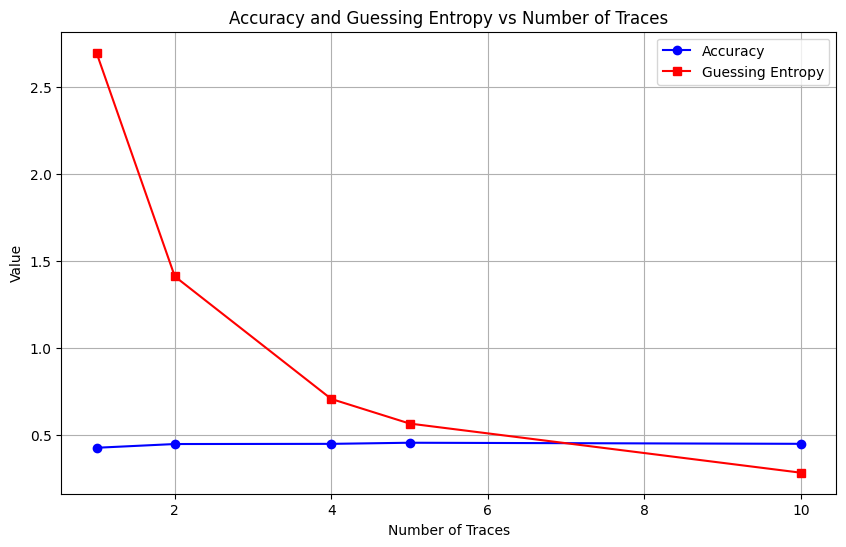

In [10]:
def plot_accuracy_ge(runs_data):
    # Extracting traces, accuracy and guessing entropy
    traces = [run['traces'] for run in runs_data]
    accuracy = [run['acc'] for run in runs_data]
    guessing_entropy = [run['ge'] for run in runs_data]

    # Creating the plot
    plt.figure(figsize=(10, 6))

    # Plotting Accuracy
    plt.plot(traces, accuracy, marker='o', color='b', label='Accuracy')

    # Plotting Guessing Entropy
    plt.plot(traces, guessing_entropy, marker='s', color='r', label='Guessing Entropy')

    # Adding titles and labels
    plt.title('Accuracy and Guessing Entropy vs Number of Traces')
    plt.xlabel('Number of Traces')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
plot_accuracy_ge(results)